In [1]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import cmocean
import xarray as xr
import xroms
import glob
import os
import datetime
import numpy as np
import dateutil
import dask

import collections.abc
collections.Iterable = collections.abc.Iterable
import xscale

In [2]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster(dashboard_address=':8787')
w = cluster.scale(5*14)
client = Client(cluster)

2025-06-25 11:31:00,432 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:34269' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('mean_chunk-3cfa330f3f29e1b70f889c4c72b57a40', 5661, 0, 0), ('mean_chunk-3cfa330f3f29e1b70f889c4c72b57a40', 5739, 0, 0), ('mean_combine-partial-bf6c0605355e179c4a34e5d8ea2e78eb', 1991, 0, 0), ('mean_chunk-3cfa330f3f29e1b70f889c4c72b57a40', 4229, 0, 0), ('mean_combine-partial-bf6c0605355e179c4a34e5d8ea2e78eb', 1222, 0, 0), ('mean_chunk-3cfa330f3f29e1b70f889c4c72b57a40', 5823, 0, 0)} (stimulus_id='handle-worker-cleanup-1750840260.4324505')
2025-06-25 11:31:00,437 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:46717' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('mean_chunk-3cfa330f3f29e1b70f889c4c72b57a40', 5441, 0, 0), ('mean_chunk-3cfa330f3f29e1b70f889c4c72b57a40', 5610, 0, 0), ('mean_chunk-3cfa330f3f29e1b70f889c4c72b57a40', 5830, 0

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 70
Total threads: 560,Total memory: 1.07 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43759,Workers: 70
Dashboard: http://127.0.0.1:8787/status,Total threads: 560
Started: 10 minutes ago,Total memory: 1.07 TiB
Comm: tcp://127.0.0.1:43155,Total threads: 8
Dashboard: http://127.0.0.1:41327/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:35333,


In [3]:
data_path = '/southern/rbarkan/data/SWC2km/OUTPUT/W_rivers/HIS/'
save_path = '/meddy/lwang/data/SWC2km_Wrivers_data/'
figure_dir = '/meddy/lwang/figures/KE_exchanges/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

In [7]:
grd = xr.open_dataset('/southern/rbarkan/data/SWC2km/SWC2km_grd.nc')

In [8]:
filenames = sorted(glob.glob(data_path+'z_SWC2km_his.*.nc')) 
print('Number of files processed: %d' %len(filenames))
ds = xr.open_mfdataset(filenames, concat_dim='time', combine="nested")
ds

Number of files processed: 1460


<xarray.Dataset> Size: 2TB
Dimensions:     (time: 8760, depth: 5, eta_rho: 1296, xi_u: 1501, eta_v: 1295,
                 xi_rho: 1502)
Coordinates:
  * depth       (depth) float32 20B -2.0 -100.0 -500.0 -1e+03 -4e+03
Dimensions without coordinates: time, eta_rho, xi_u, eta_v, xi_rho
Data variables:
    ocean_time  (time) float64 70kB dask.array<chunksize=(6,), meta=np.ndarray>
    time_step   (time) int32 35kB dask.array<chunksize=(6,), meta=np.ndarray>
    u           (time, depth, eta_rho, xi_u) float32 341GB dask.array<chunksize=(6, 5, 1296, 1501), meta=np.ndarray>
    v           (time, depth, eta_v, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1295, 1502), meta=np.ndarray>
    temp        (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    salt        (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    w           (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akv         (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>
    Akt         (time, depth, eta_rho, xi_rho) float32 341GB dask.array<chunksize=(6, 5, 1296, 1502), meta=np.ndarray>

In [9]:
ds['pm']= (['eta_rho', 'xi_rho'],grd['pm'].data)
ds['pn']= (['eta_rho', 'xi_rho'],grd['pn'].data)
ds['f']= (['eta_rho', 'xi_rho'],grd['f'].data)

ds, xgrid = xroms.roms_dataset(ds, include_cell_volume=True)
ds.xroms.set_grid(xgrid)

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xroms/xroms.py:135: RuntimeWarning: need 3D Dataset in order to calculate 3D metrics.
  warnings.warn(
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. T

In [10]:
ds_u = ds['u'].isel(depth=0)
ds_v = ds['v'].isel(depth=0)

In [11]:
print('\n data size: %.1f GB' %(ds_u.nbytes / 1e9))
print('\n data size: %.1f GB' %(ds_v.nbytes / 1e9))


 data size: 68.2 GB

 data size: 68.2 GB


In [12]:
def oceantime_to_date(oceantime):
    t0 = datetime.datetime(2000,1,1)    
    ltime = np.array(oceantime)
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

    
dtime = oceantime_to_date(ds['ocean_time'])

In [13]:
ds_u = ds_u.assign_coords(time=dtime) 
ds_v = ds_v.assign_coords(time=dtime) 

In [14]:
ds_u = ds_u.chunk({'time': 1, 'eta_rho': 1296, 'xi_u': 1501})
ds_v = ds_v.chunk({'time': 1, 'eta_v': 1295, 'xi_rho': 1502})
print(ds_u)
print(ds_v)

<xarray.DataArray 'u' (time: 8760, eta_rho: 1296, xi_u: 1501)> Size: 68GB
dask.array<rechunk-merge, shape=(8760, 1296, 1501), dtype=float32, chunksize=(1, 1296, 1501), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 4B -2.0
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
Attributes:
    long_name:  u-momentum component
    units:      meter second-1
<xarray.DataArray 'v' (time: 8760, eta_v: 1295, xi_rho: 1502)> Size: 68GB
dask.array<rechunk-merge, shape=(8760, 1295, 1502), dtype=float32, chunksize=(1, 1295, 1502), chunktype=numpy.ndarray>
Coordinates:
    depth    float32 4B -2.0
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_v    (eta_v) int64 10kB 0 1 2 3 4 5 6 ... 1289 1290 1291 1292 1293 1294
  * time     (time) datetime64[ns] 70kB 2016-07-3

In [ ]:
%%time
ds_u.to_zarr(save_path+'surface_u_nointerp_rechunk.zarr',mode='w')
ds_v.to_zarr(save_path+'surface_v_nointerp_rechunk.zarr',mode='w')

### Relative vorticity

In [59]:
zeta = xroms.relative_vorticity(ds_u,ds_v, xgrid)
zeta = zeta.chunk({'time': 1, 'eta_v': 1295, 'xi_u': 1501})

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [25]:
lat=grd['lat_rho'].mean().values
omega = 7.2921*1e-5
f=2*omega*np.sin(np.deg2rad(lat))

In [61]:
%%time
zeta.to_zarr(save_path+'relative_vorticity_rechunk.zarr',mode='w')

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 50.21 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 43min 39s, sys: 33min 49s, total: 1h 17min 29s
Wall time: 5h 34min 14s


In [32]:
zeta

<xarray.DataArray 'vort' (time: 36, eta_v: 1295, xi_u: 1501)> Size: 560MB
dask.array<rechunk-merge, shape=(36, 1295, 1501), dtype=float64, chunksize=(1, 1295, 1501), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 288B 2016-07-31T23:21:32 ... 2016-08-02T10...
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
  * eta_v    (eta_v) int64 10kB 0 1 2 3 4 5 6 ... 1289 1290 1291 1292 1293 1294
Attributes:
    long_name:  vertical component of vorticity
    units:      1/s
    name:       vort

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 29.67 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


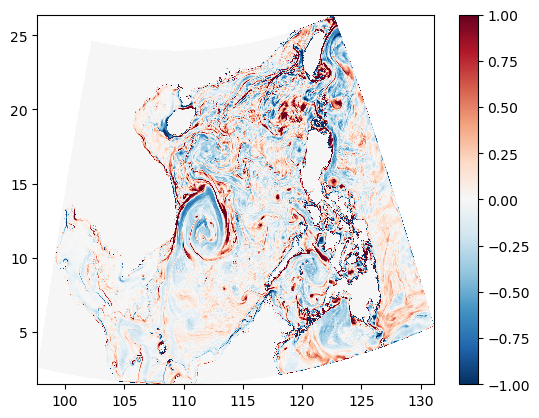

In [44]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])

plt.pcolormesh(lon, lat, zeta.mean(dim='time')/f, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

In [22]:
ds_vrt = xr.open_zarr(save_path + 'relative_vorticity_rechunk.zarr')
print(ds_vrt)
print('\n data size: %.1f GB' %(ds_vrt.nbytes / 1e9))


<xarray.Dataset> Size: 136GB
Dimensions:  (eta_v: 1295, time: 8760, xi_u: 1501)
Coordinates:
  * eta_v    (eta_v) int64 10kB 0 1 2 3 4 5 6 ... 1289 1290 1291 1292 1293 1294
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
Data variables:
    vort     (time, eta_v, xi_u) float64 136GB dask.array<chunksize=(1, 1295, 1501), meta=np.ndarray>

 data size: 136.2 GB


In [15]:
#vrt = xroms.relative_vorticity(ds_u,ds_v, xgrid)

dvdxi = xroms.hgrad(
    ds_v,
    xgrid,
    which="xi",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)
dudeta = xroms.hgrad(
    ds_u,
    xgrid,
    which="eta",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)

vrt = dvdxi - dudeta

vrt.attrs["name"] = "vort"
vrt.attrs["long_name"] = "vertical component of vorticity"
vrt.attrs["units"] = "1/s"
vrt.name = vrt.attrs["name"]

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [16]:
vrt

<xarray.DataArray 'vort' (time: 8760, eta_v: 1295, xi_u: 1501)> Size: 136GB
dask.array<sub, shape=(8760, 1295, 1501), dtype=float64, chunksize=(1, 1295, 1501), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
  * eta_v    (eta_v) int64 10kB 0 1 2 3 4 5 6 ... 1289 1290 1291 1292 1293 1294
Attributes:
    long_name:  vertical component of vorticity
    units:      1/s
    name:       vort

### Horizontal divergence

In [17]:
#div = xroms.convergence(ds_u,ds_v, xgrid)
dudxi = xroms.hgrad(
    ds_u,
    xgrid,
    which="xi",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)
dvdeta = xroms.hgrad(
    ds_v,
    xgrid,
    which="eta",
    hboundary="extend",
    hfill_value=None,
    sboundary="extend",
    sfill_value=None,
)

div = dudxi + dvdeta

div.attrs["name"] = "divergence"
div.attrs["long_name"] = "horizontal divergence"
div.attrs["units"] = "1/s"
div.name = div.attrs["name"]

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [18]:
div

<xarray.DataArray 'divergence' (time: 8760, eta_rho: 1296, xi_rho: 1502)> Size: 136GB
dask.array<add, shape=(8760, 1296, 1502), dtype=float64, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
Dimensions without coordinates: time
Attributes:
    long_name:  horizontal divergence
    units:      1/s
    name:       divergence

In [19]:
div = div.assign_coords(time=dtime)
div

<xarray.DataArray 'divergence' (time: 8760, eta_rho: 1296, xi_rho: 1502)> Size: 136GB
dask.array<add, shape=(8760, 1296, 1502), dtype=float64, chunksize=(1, 1296, 1502), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho   (xi_rho) int64 12kB 0 1 2 3 4 5 6 ... 1496 1497 1498 1499 1500 1501
  * eta_rho  (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1290 1291 1292 1293 1294 1295
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
Attributes:
    long_name:  horizontal divergence
    units:      1/s
    name:       divergence

In [ ]:
%%time
div = div.chunk({'time': 1, 'eta_rho': 1296, 'xi_rho': 1502})
div.to_zarr(save_path+'surface_horizontal_divergence_rechunk.zarr',mode='w')

/home/lwang/anaconda3/envs/swc_env/lib/python3.10/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 70.56 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [6]:
ds_div = xr.open_zarr(save_path + 'surface_horizontal_divergence_rechunk.zarr')
print(ds_div)
print('\n data size: %.1f GB' %(ds_div.nbytes / 1e9))

<xarray.Dataset> Size: 136GB
Dimensions:     (time: 8760, eta_rho: 1296, xi_rho: 1502)
Coordinates:
  * eta_rho     (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1291 1292 1293 1294 1295
  * xi_rho      (xi_rho) int64 12kB 0 1 2 3 4 5 ... 1497 1498 1499 1500 1501
Dimensions without coordinates: time
Data variables:
    divergence  (time, eta_rho, xi_rho) float64 136GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

 data size: 136.4 GB


In [22]:
ds_div

<xarray.Dataset> Size: 136GB
Dimensions:     (time: 8760, eta_rho: 1296, xi_rho: 1502)
Coordinates:
  * eta_rho     (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1291 1292 1293 1294 1295
  * xi_rho      (xi_rho) int64 12kB 0 1 2 3 4 5 ... 1497 1498 1499 1500 1501
Dimensions without coordinates: time
Data variables:
    divergence  (time, eta_rho, xi_rho) float64 136GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [28]:
ds_div = ds_div.assign_coords(time=dtime)
ds_div

<xarray.Dataset> Size: 136GB
Dimensions:     (time: 8760, eta_rho: 1296, xi_rho: 1502)
Coordinates:
  * eta_rho     (eta_rho) int64 10kB 0 1 2 3 4 5 ... 1291 1292 1293 1294 1295
  * xi_rho      (xi_rho) int64 12kB 0 1 2 3 4 5 ... 1497 1498 1499 1500 1501
  * time        (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31...
Data variables:
    divergence  (time, eta_rho, xi_rho) float64 136GB dask.array<chunksize=(1, 1296, 1502), meta=np.ndarray>

In [ ]:
%%time
ds_div = ds_div.chunk({'time': 1, 'eta_rho': 1296, 'xi_rho': 1502})
ds_div.to_zarr(save_path+'surface_horizontal_divergence_rechunk.zarr',mode='w')

/tmp/ipykernel_954760/546591667.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon, lat, ds_div.divergence[-2,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')


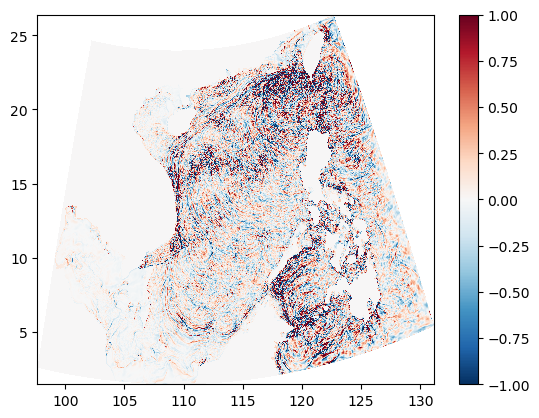

In [27]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])

plt.pcolormesh(lon, lat, ds_div.divergence[-2,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

In [30]:
ds_vrt = xr.open_zarr(save_path + 'surface_relative_vorticity_rechunk.zarr')

In [31]:
ds_vrt

<xarray.Dataset> Size: 136GB
Dimensions:  (eta_v: 1295, time: 8760, xi_u: 1501)
Coordinates:
  * eta_v    (eta_v) int64 10kB 0 1 2 3 4 5 6 ... 1289 1290 1291 1292 1293 1294
  * time     (time) datetime64[ns] 70kB 2016-07-31T23:21:32 ... 2017-07-31T22...
  * xi_u     (xi_u) int64 12kB 0 1 2 3 4 5 6 ... 1495 1496 1497 1498 1499 1500
Data variables:
    vort     (time, eta_v, xi_u) float64 136GB dask.array<chunksize=(1, 1295, 1501), meta=np.ndarray>

/tmp/ipykernel_954760/213272780.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(lon, lat, ds_div.divergence[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')


Text(0.5, 1.0, '${\\delta}/f$')

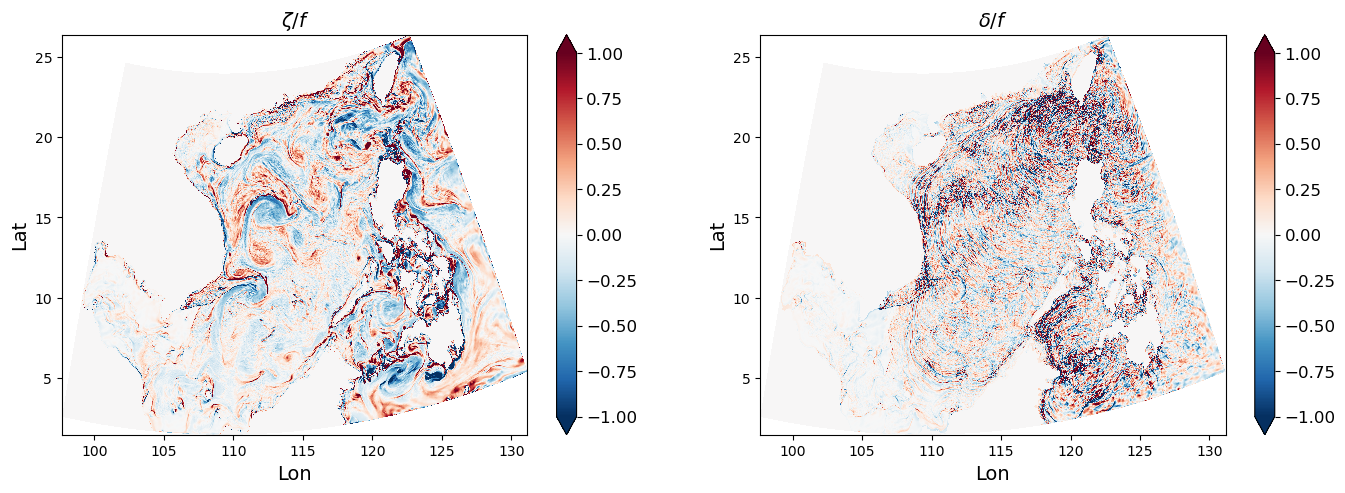

In [42]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])

fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

ax = fig.add_subplot(121)
plot = ax.pcolormesh(lon, lat, ds_vrt.vort[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\zeta/f$', fontsize=14)

ax = fig.add_subplot(122)
plot = ax.pcolormesh(lon, lat, ds_div.divergence[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\delta/f$', fontsize=14)

In [46]:
ds_vrt_daily = ds_vrt.resample(time='D').mean()
ds_div_daily = ds_div.resample(time='D').mean()

/tmp/ipykernel_954760/1501493950.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(lon, lat, ds_div_daily.divergence[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')


Text(0.5, 1.0, '${\\delta}/f$')

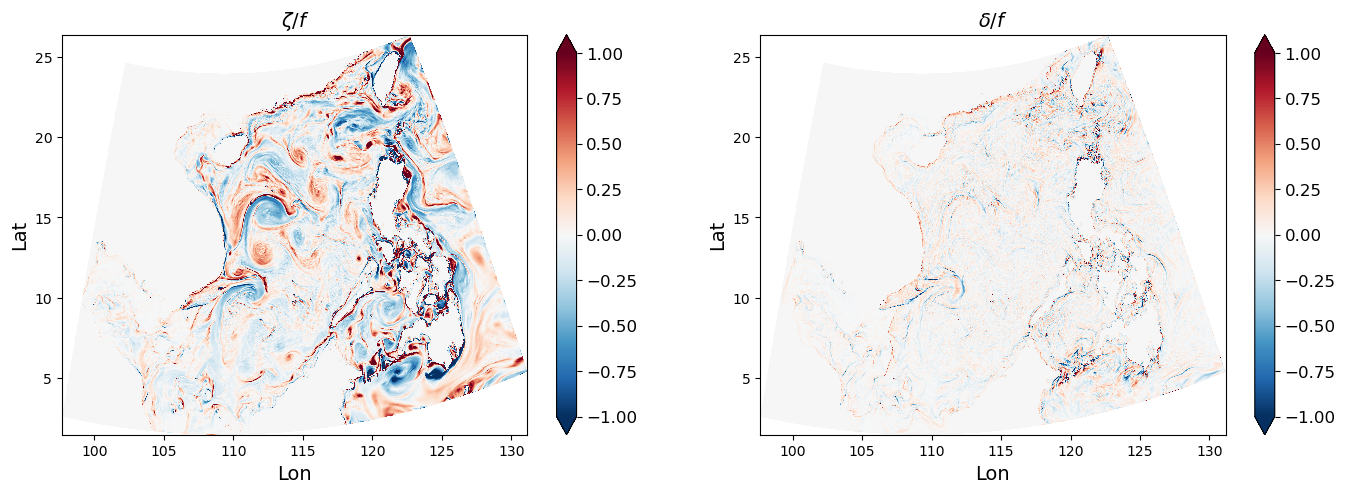

In [49]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])

fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

ax = fig.add_subplot(121)
plot = ax.pcolormesh(lon, lat, ds_vrt_daily.vort[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\zeta/f$', fontsize=14)

ax = fig.add_subplot(122)
plot = ax.pcolormesh(lon, lat, ds_div_daily.divergence[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\delta/f$', fontsize=14)

In [50]:
ds_vrt_2day = ds_vrt.resample(time='2D').mean()
ds_div_2day = ds_div.resample(time='2D').mean()

/tmp/ipykernel_954760/1787038631.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax.pcolormesh(lon, lat, ds_div_2day.divergence[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')


Text(0.5, 1.0, '${\\delta}/f$')

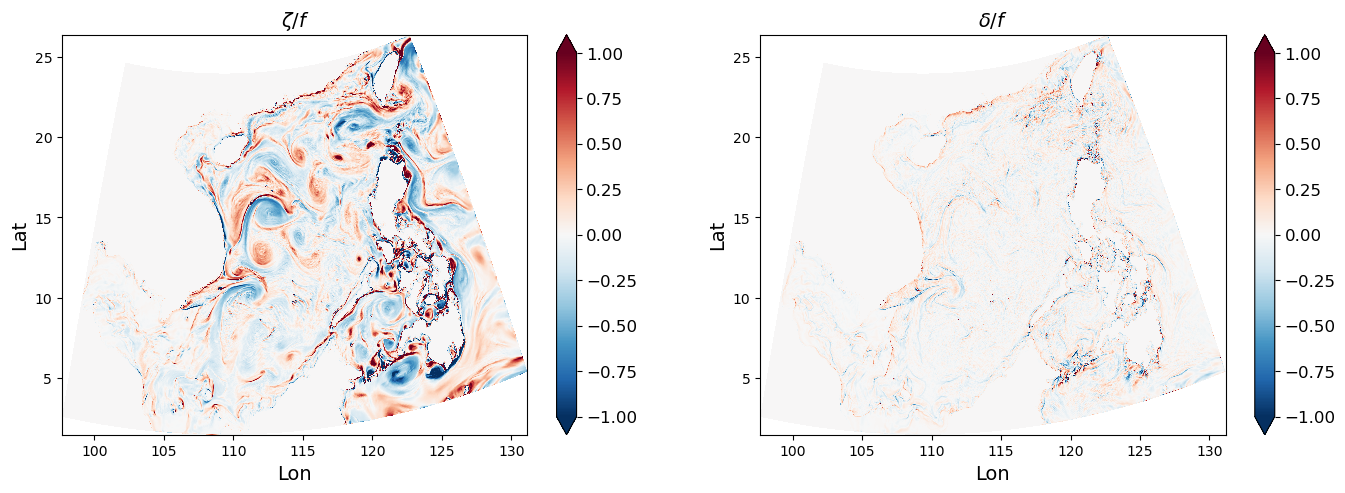

In [51]:
lat, lon = np.array(grd['lat_rho']), np.array(grd['lon_rho'])

fig = plt.figure(figsize=(16, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

ax = fig.add_subplot(121)
plot = ax.pcolormesh(lon, lat, ds_vrt_2day.vort[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\zeta/f$', fontsize=14)

ax = fig.add_subplot(122)
plot = ax.pcolormesh(lon, lat, ds_div_2day.divergence[-1,:,:]/f, vmin=-1, vmax=1, cmap='RdBu_r')
cbar = fig.colorbar(plot,ax=ax,extend='both')
cbar.ax.tick_params(labelsize='large')
ax.set_xlabel('Lon', fontsize=14)
ax.set_ylabel('Lat',fontsize=14)
ax.set_title(r'$\delta/f$', fontsize=14)

### Buoyancy

In [ ]:
sig0 = xroms.potential_density(ds.temp, ds.salt);
buoy = xroms.buoyancy(sig0)